## Preparación para el Modelado

Con base en la exploración inicial del dataset de características derivadas del intervalo RR, se tomaron las siguientes decisiones para mejorar el rendimiento del modelo de clasificación:

### 1. Balanceo de Clases con SMOTE
Se observó un fuerte desbalance entre las clases: la mayoría de las muestras corresponden a ritmo normal (N) y solo unas pocas a fibrilación auricular (A). Para mitigar este desequilibrio y evitar que el modelo favorezca la clase mayoritaria, se aplicará la técnica **SMOTE (Synthetic Minority Over-sampling Technique)**, generando ejemplos sintéticos de la clase minoritaria.

### 2. Eliminación de Outliers
Se detectaron valores extremos en las variables obtenidas, con máximos considerablemente alejados del rango intercuartílico. Estos outliers pueden afectar negativamente el proceso de entrenamiento. Se utilizará la técnica del **IQR (Interquartile Range)** para identificar y eliminar registros atípicos por variable.

### 3. Ajuste de Hiperparámetros
Una vez establecido el modelo base (Random Forest), se realizará una búsqueda sistemática de hiperparámetros utilizando **GridSearchCV**.




## Justificación del uso de Random Forest

Random Forest es una opción adecuada para este problema porque puede manejar relaciones no lineales entre las variables estadísticas del intervalo RR sin necesidad de preprocesamiento complejo. Es resistente al ruido y a valores atípicos, lo que es útil en datos fisiológicos. Además, al combinar múltiples árboles, reduce el riesgo de sobreajuste y permite estimar la importancia de las variables, lo cual es útil para interpretar el modelo y guiar posibles mejoras.


Original: 5774 registros
Limpios con feature-engine: 5226 registros
Fitting 5 folds for each of 48 candidates, totalling 240 fits


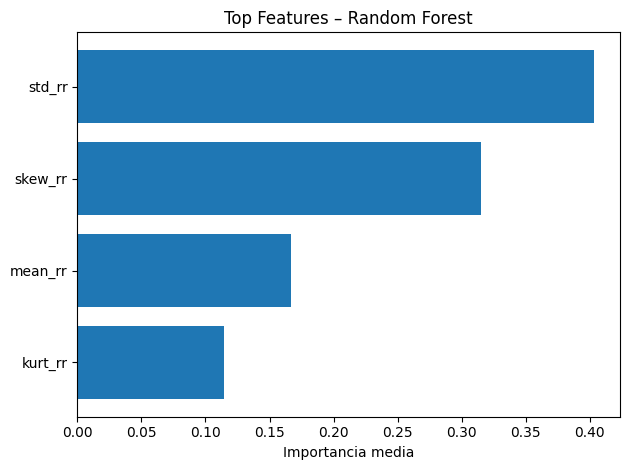


Mejores hiperparámetros encontrados:
{'class_weight': None, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Reporte por clase:
              precision    recall  f1-score   support

           A       0.88      0.86      0.87       133
           N       0.98      0.98      0.98       913

    accuracy                           0.97      1046
   macro avg       0.93      0.92      0.92      1046
weighted avg       0.97      0.97      0.97      1046



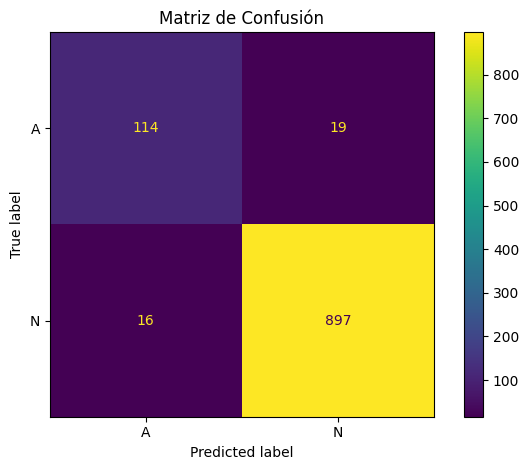

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from feature_engine.outliers import OutlierTrimmer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, ConfusionMatrixDisplay
)
from sklearn.model_selection import GridSearchCV, train_test_split

# Cargar datos
df = pd.read_csv("../data/ecg_rr_features_curado.csv")

# Columnas numéricas
columnas = ["mean_rr", "std_rr", "skew_rr", "kurt_rr"]

# Separar por clase
df_n = df[df['label'] == 'N']
df_a = df[df['label'] == 'A']

# Cantidad de registros antes de limpieza de outliers
print(f"Original: {len(df)} registros")

# Crear el trimmer para cada clase, utilizando el método IQR y un parámetro conservador de fold=2
trimmer_n = OutlierTrimmer(capping_method='iqr', tail='both', fold=2, variables=columnas)
df_n_clean = trimmer_n.fit_transform(df_n)

trimmer_a = OutlierTrimmer(capping_method='iqr', tail='both', fold=2, variables=columnas)
df_a_clean = trimmer_a.fit_transform(df_a)

# Unir las clases limpias
df = pd.concat([df_n_clean, df_a_clean], ignore_index=True)

# Mostrar número de registros después de limpieza
print(f"Después de la limpieza: {len(df)} registros")

# Separar características y etiquetas
X = df.drop(columns=["record", "label"])
y = df["label"]

# Barajar dataset completo antes de dividir
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# División en conjuntos de entrenamiento y prueba; stratify para dejar la proporción de clases
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Aplicar SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Barajar después del SMOTE
df_train_smote = pd.concat([X_train_smote, y_train_smote], axis=1)
df_train_smote = df_train_smote.sample(frac=1, random_state=42).reset_index(drop=True)
X_train_smote = df_train_smote.drop(columns=["label"])
y_train_smote = df_train_smote["label"]

# GridSearchCV para Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': [None, 'balanced']
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

# Entrenamiento del modelo con GridSearchCV
grid.fit(X_train_smote, y_train_smote)
# Mejor modelo encontrado
clf = grid.best_estimator_

# Importancia de variables
importances = clf.feature_importances_
feat_names = X.columns
idx = np.argsort(importances)[::-1][:15]
plt.barh(range(len(idx)), importances[idx][::-1])
plt.yticks(range(len(idx)), feat_names[idx][::-1])
plt.xlabel("Importancia media")
plt.title("Top Features – Random Forest")
plt.tight_layout()
plt.show()

# Evaluación
y_pred = clf.predict(X_test)

print("\nMejores hiperparámetros encontrados:")
print(grid.best_params_)
print("\nReporte por clase:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.show()


## Análisis de Resultados

### Descripción de métricas

- **Precision (Precisión):**  
  Proporción de predicciones positivas que fueron correctas. En el contexto médico, es importante para evitar falsos diagnósticos de AFib.

- **Recall (Sensibilidad):**  
  Proporción de casos reales positivos que fueron correctamente identificados. Es clave en problemas médicos donde no detectar un caso de AFib puede tener consecuencias graves.

- **F1-score:**  
  Media armónica entre precisión y recall. Resume el balance entre ambas métricas, útil especialmente con clases desbalanceadas.

- **Support (Soporte):**  
  Cantidad de muestras reales por clase. En este caso: 913 registros normales (N) y 133 con fibrilación auricular (A).

- **Accuracy (Exactitud):**  
  Porcentaje de predicciones correctas sobre el total. Es útil como métrica general, aunque puede ser engañosa si hay desbalance de clases.

- **Macro avg:**  
  Promedio simple de las métricas por clase, sin considerar el tamaño de cada clase.

- **Weighted avg:**  
  Promedio ponderado por la cantidad de muestras por clase. Refleja mejor el desempeño global en conjuntos desbalanceados.

---

### Resultados obtenidos

| Clase | Precision | Recall | F1-score | Support |
|-------|-----------|--------|----------|---------|
| A (AFib) | 0.88 | 0.86 | 0.87 | 133 |
| N (Normal) | 0.98 | 0.98 | 0.98 | 913 |

- **Exactitud total:** 0.97  
- **Macro F1-score:** 0.92  
- **F1-score en clase A:** 0.87

El modelo tiene un excelente desempeño general. La clase mayoritaria (N) se clasifica con alta precisión y exhaustividad, mientras que la clase minoritaria (A) también obtiene métricas robustas, especialmente considerando su menor presencia en el dataset.

---

### Aspectos positivos

- Alta exactitud global (97%) con muy buen balance entre clases.
- Buen manejo del desbalance gracias a SMOTE.
- Optimización adecuada mediante GridSearchCV.
- Eliminación cuidadosa de outliers por clase (fold=2), lo cual mejora la calidad de los datos sin eliminar demasiadas muestras.
- El modelo Random Forest permite interpretar la importancia de las variables, útil en aplicaciones clínicas.

---

### Cosas a mejorar

- Recall en la clase A (0.86): algunos casos de AFib no están siendo detectados. Esto podría implicar riesgo clínico si se aplicara en la práctica real.
- Explorar modelos complementarios como SVM, Gradient Boosting o redes neuronales livianas.
- Incorporar nuevas características estadísticas o fisiológicas (e.g., medidas de HRV, entropía, transformadas wavelet).
- Explorar técnicas de interpretación del modelo para identificar errores frecuentes y mejorar la sensibilidad clínica.

---

### Conclusión

El modelo Random Forest entrenado con estadísticas simples del intervalo RR logra una clasificación precisa y balanceada de ritmos normales y fibrilación auricular. Este resultado valida que técnicas de aprendizaje automático relativamente sencillas pueden ser efectivas en contextos médicos, siempre que se acompañen de buen preprocesamiento, balanceo de clases y validación rigurosa. Para aplicaciones clínicas reales, se recomienda seguir mejorando la sensibilidad del modelo hacia la clase minoritaria y validar su desempeño con datos independientes.
